Andreev spectrum of nanostructure-based junction
syst1: TI system without TRS

# import Kwant

In [3]:
import kwant
print(kwant.version.version)

import matplotlib

import matplotlib.pyplot as plt
#plt.style.use('genstyle')

import pandas as pd

import scipy.sparse.linalg as sla

import numpy as np
import kwant
import kwant.continuum
import peierls as peierls

import adaptive
import holoviews as hv
from holoviews import opts
adaptive.notebook_extension()
from concurrent.futures import ProcessPoolExecutor
from operator import itemgetter

import  sympy
from sympy.physics.matrices import msigma, Matrix
from sympy import eye
from sympy.physics.quantum import TensorProduct

from sympy.utilities.exceptions import SymPyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)


import scipy.signal
from scipy.stats import multivariate_normal

C:\MARTIN\Anaconda\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


1.4.2


In [4]:
pd.options.display.float_format = "{:,.2f}".format

# System creation

In [5]:
import numpy as np

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

L_x = 100
W_y = 100
H_z = 100

## 3DTI hamiltonian

In [6]:
import kwant.continuum


norbs = 8 # 8 orbitals (2 for particle-hole x 2 for spin up-down x 2 for orbitals A/B)
ham_TI = ("- mu_bulk * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) + "
          "S_mag * S_imp(site) * kron(sigma_z, sigma_0, sigma_0)")

ham_TI_lead1 = ("- mu_lead1 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")

ham_TI_lead2 = ("- mu_lead2 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")


epsilon = "(C_0 - C_perp * (k_x**2 + k_y**2) - C_z * k_z**2)"
M = "(M_0 - M_perp * (k_x**2 + k_y**2) - M_z * k_z**2)"

ham_TI = ham_TI.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)


ham_TI_lead1 = ham_TI_lead1.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead1, coords = kwant.continuum.discretize_symbolic(ham_TI_lead1)

ham_TI_lead2 = ham_TI_lead2.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead2, coords = kwant.continuum.discretize_symbolic(ham_TI_lead2)


signs = [-1, -1, -1, -1, 1, 1, 1, 1]
vector_potential='[-B_z * y, -B_x * z, -B_y * x]'
ham_discr = peierls.apply(ham_discr, coords, A=vector_potential, signs=signs)
ham_discr_lead1 = peierls.apply(ham_discr_lead1, coords, A=vector_potential, signs=signs)
ham_discr_lead2 = peierls.apply(ham_discr_lead2, coords, A=vector_potential, signs=signs)

In [7]:
a = 10
ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead1, coords, grid=a)
ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead2, coords, grid=a)

In [8]:
syst1 = kwant.Builder()
_ = syst1.fill(ti_syst, *get_shape(L_x, W_y, H_z))

lat = kwant.lattice.cubic(a, norbs=norbs)

In [9]:
sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
conservation_law = -np.kron(sigma_z, np.kron(sigma_0, sigma_0))
particle_hole = np.kron(sigma_x, np.kron(sigma_0, sigma_0))
sigma_TR = np.array([[0, -1], [1, 0]])
# i*sigma_y
time_reversal = np.kron(sigma_z, np.kron(sigma_TR, sigma_0))

nleads = 2

lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )
lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )

lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
lead_1.fill(ti_lead_1, *get_shape_lead_1(L_x, W_y, H_z))

syst1.attach_lead(lead_0)
syst1.attach_lead(lead_1)

[]

In [10]:
systf1 = syst1.finalized()

## Define Disorder

### Uncorrelated Disorder

In [11]:
# Define a random number (following gaussian distribution) table for disorder
disorder_3D = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_x = np.array([[[kwant.digest.gauss(str(ind_x))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_y = np.array([[[kwant.digest.gauss(str(ind_y))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_z = np.array([[[kwant.digest.gauss(str(ind_z))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

# Uncorrelated disorder (random values for each sites). Altering the values of the chemical potentials
def get_S_imp_3D():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_3D[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_x():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_x[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_y():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_y[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_z():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_z[ind_y, ind_x, ind_z]
    return S_imp

### Correlated Disorder

In [12]:
correlation_length = 10# in units of a (lattice constant)
#Smag_imp = 0.05

x, y, z = np.mgrid[-3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1]
pos = np.stack((x, y, z), axis=3)
rv = multivariate_normal([0, 0, 0], [[correlation_length**2, 0, 0], [0, correlation_length**2, 0], [0, 0, correlation_length**2]])
filter_kernel = rv.pdf(pos)

disorder = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_fil = scipy.signal.fftconvolve(disorder, filter_kernel, mode='same')
disorder_fil = disorder_fil/np.std(disorder_fil.flatten())

def get_S_imp_correlated():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        #return disorder[ind_y, ind_x, ind_z]
        return disorder_fil[ind_y, ind_x, ind_z]
    return S_imp

## Params dict

In [13]:
#params_toy = dict(C_0=0.0,
#                  C_2=3.0,
#                  mu=0.012
#                 )


params_toy = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0205,
                  mu_lead1=0.0205,
                  mu_lead2=0.021,
                  S_imp = get_S_imp_x(),
                  S_mag = 0.000
                 )

params_toy_sim = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0,
                 )

#params_TI = dict(A_perp=3.0,
#                 A_z=3.0,
#                 M_0=0.3,
#                 M_perp=15.0,
#                 M_z=15.0,
#                 C_0=0.0,
#                 C_perp=0.0,
#                 C_z=0.0,
#                 m_z=0.0,
#                 mu=0.1
#                )

params_TI = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu_bulk=0.04,
                 mu_lead1=0.04,
                 mu_lead2=0.04,
                 S_imp = get_S_imp_3D(), # this defines the disorder type, uncorrelated in 3D. Change 3D to correlated to have correlated dis
                 S_mag = 0.00,           # 0.01 max value, amplitude of disorder
                 B_x = 0.5/(W_y*H_z),   ## This means half flux, has to be in this direction, width and heigth of TI
                 B_y = 0,
                 B_z = 0,
                 phi_0=1.0,
                 exp=np.exp,
                 a = 10
                 )

params_TI_sim = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu=0
                )

# Andreev spectrum

## Find Bound States (helper functions)

### Single Channel

In [14]:
def energy_operator_mask(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Calibrate the phase shift
    #shift_e = np.angle(smat_e[0][1]) - np.angle(smat_e[1][0])
    #shift_matrix_e = np.block([[1, 0], [0, np.exp(1j*shift_e/2)]])    
    #smat_e = shift_matrix_e@smat_e@shift_matrix_e.conj()
    #shift_h = np.angle(smat_h[0][1]) - np.angle(smat_h[1][0])
    #shift_matrix_h = np.block([[1, 0], [0, np.exp(1j*shift_h/2)]])   
    #smat_h = shift_matrix_h@smat_h@shift_matrix_h.conj()
        
    
## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj())]

def energy_operator_block(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    size_L = int(smat.num_propagating(0)/2)
    size_R = int(smat.num_propagating(1)/2)
        
    smat_e = np.block([[smat.submatrix((0,0),(0,0)), smat.submatrix((0,0),(1,0))],
         [smat.submatrix((1,0),(0,0)), smat.submatrix((1,0),(1,0))]])
    smat_h = np.block([[smat.submatrix((0,1),(0,1)), smat.submatrix((0,1),(1,1))],
         [smat.submatrix((1,1),(0,1)), smat.submatrix((1,1),(1,1))]])
    
    smat_h_copy = np.array(list(smat_h))
    


    
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Calibrate the phase shift
    #shift_e = np.angle(smat_e[0][1]) - np.angle(smat_e[1][0])
    #shift_matrix_e = np.block([[1, 0], [0, np.exp(1j*shift_e/2)]])    
    #smat_e = shift_matrix_e@smat_e@shift_matrix_e.conj()
    #shift_h = np.angle(smat_h[0][1]) - np.angle(smat_h[1][0])
    #shift_matrix_h = np.block([[1, 0], [0, np.exp(1j*shift_h/2)]])   
    #smat_h = shift_matrix_h@smat_h@shift_matrix_h.conj()
    
## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj())]


def e_squared_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='mask'):
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.linalg.eigvalsh(operator[2])

def energies_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='mask'):
    """Same as energy_operator(), but returns the 
    square-root of the eigenvalues"""
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.sqrt(np.linalg.eigvalsh(operator[2]))

def plot_ABS_spectrum(syst, p, phases, n=3, ph_sym=False, method='mask', r=False):
    params = p.copy()
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi/\pi$')
    ax.set_ylabel(r'$E/\Delta$')

    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta(syst, params, ph_sym=ph_sym, phases=phase, method=method))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    i = 0
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=str(i))
        ax.plot(phases, -1*sol, 'C'+str(i))
        i+=1
    ax.legend()
    if r:
        return sol_list2
    
def find_gap(syst, p, n=0, ph_sym=False, method='mask'):
    phases = [0, np.pi]
    return 2*energies_over_delta(syst, p, ph_sym=ph_sym, phases=phases, method=method)[n]

### Multichannel

In [15]:
def energy_operator_calibrated(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    calibration_e = np.identity(size_L+size_R, dtype=complex)
    calibration_h = np.identity(size_L+size_R, dtype=complex)

## Assuming the left lead and the right lead have the same dimensions (same number of propagating modes)
    for i in range(0, size_L):
        smat_e_channel = np.block([
            [smat_e[i][i], smat_e[i][i+size_L]],
            [smat_e[i+size_L][i], smat_e[i+size_L][i+size_L]]
        ])
        smat_h_channel = np.block([
            [smat_h[i][i], smat_h[i][i+size_L]],
            [smat_h[i+size_L][i], smat_h[i+size_L][i+size_L]]
        ])
        
        #print(smat_e_channel)
        
    ## Calibrate the phase shift
        shift_e = np.angle(smat_e[i][i+size_L]) - np.angle(smat_e[i+size_L][i])
        calibration_e[i+size_L][i+size_L] = np.exp(1j*shift_e/2)
        shift_h = np.angle(smat_h[i][i+size_L]) - np.angle(smat_h[i+size_L][i])
        calibration_h[i+size_L][i+size_L] = np.exp(1j*shift_h/2)
    
    smat_e = calibration_e@smat_e@calibration_e.conj()
    smat_h = calibration_h@smat_h@calibration_h.conj()
        

#    Use particle-hole symmetry    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) + 0.25 * (smat_prod + smat_prod.T.conj())]



def energies_over_delta_calibrated(syst, p, ph_sym=True, phases=np.zeros(nleads)):
    operator = energy_operator_calibrated(syst, p, ph_sym, phases)
    return np.sqrt(np.linalg.eigvalsh(operator[2]))

def plot_ABS_spectrum_calibrated(syst, p, phases, ph_sym=True, r=False):

    params = p.copy()
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi/\pi$')
    ax.set_ylabel(r'$E/\Delta$')

    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(syst, params, ph_sym=ph_sym, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    i = 0
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=str(i))
        ax.plot(phases, -1*sol, 'C'+str(i))
        i+=1
    ax.legend()
    if r:
        return sol_list2
    
def find_gap(syst, p, n=0, ph_sym=True):
    phases = [0, np.pi]
    return 2*energies_over_delta_calibrated(syst, p, ph_sym=ph_sym, phases=phases)[n]

## Test

### Find single channel potential

In [ ]:
mus = np.linspace(0, 0.4, 401)
channels = np.zeros((mus.shape[0]))

time_start = time.time()

params_TI['mu_bulk'] = 0.01

for index_S, mu_S in enumerate(mus):
    params_TI['mu_lead1'] = mu_S
    params_TI['mu_lead2'] = mu_S
    smat = kwant.smatrix(systf1, params=params_TI)

    channels[index_S] = (smat.num_propagating(0))

    time_current = time.time()
    percentage = (index_S + 1)/mus.shape[0]
    time_left = (time_current - time_start)/percentage - (time_current - time_start) 

    print("Time elapsed : ", time_current - time_start, "Time remaining : ", time_left, "Percentage : ", percentage*100)


np.savetxt(fname = f".\\Data\\mu_TI_to_S_{mus.shape[0]}_{mus[-1]}.txt", X = channels)

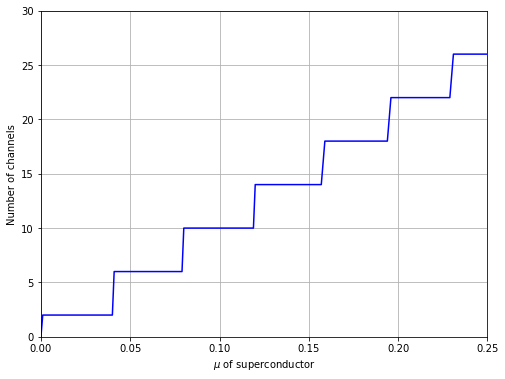

In [16]:
dimension = 401 # 50, 50, 401
max_value = 0.4 # 1, 0.04, 0.4

#channels = np.loadtxt(fname = f".\\Data\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.txt")
channels = np.loadtxt(fname = f".\\Data\\mu_TI_to_S_{dimension}_{max_value}.txt")

mu_ti = np.linspace(0, max_value, dimension)
"""
mu_super = mu_ti

plt.pcolormesh(mu_ti,mu_super , channels, shading='nearest')
plt.colorbar()

plt.ylabel('$\mu$ of normal region')
plt.xlabel('$\mu$ of superconductor')
#plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.pdf")
plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{max_value}.pdf")

plt.show()
"""
plt.figure(figsize = (8,6))
plt.plot(mu_ti, channels,"b")
plt.xlabel('$\mu$ of superconductor')
plt.ylabel('Number of channels')
plt.grid()
plt.xlim(0, 0.25)
plt.ylim(0, 30)
plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{max_value}.pdf")
plt.show()

### Check Scattering Matrix

#### Uncalibrated with random phase shift

In [32]:
mu = 0.042
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
result = energy_operator_mask(systf1, params_TI, ph_sym=False)
smat_e = pd.DataFrame(result[0])
smat_h = pd.DataFrame(result[1])
print(smat_e)
print(smat_h)
#sol = energies_over_delta(systf1, params_TI, phases=[0, np.pi], method='mask')
#print(sol)

            0           1           2           3           4           5
0 -0.00-0.00j  0.02-0.01j  0.01+0.02j  0.45+0.89j  0.03-0.02j -0.01+0.03j
1  0.01+0.02j  0.01-0.05j  0.00-0.00j  0.01-0.03j  0.99+0.10j  0.01+0.03j
2 -0.00+0.02j  0.00-0.00j -0.04-0.03j -0.03+0.02j -0.02+0.02j  0.95+0.31j
3  0.76+0.65j -0.03+0.00j  0.01+0.03j  0.00-0.00j -0.02+0.01j -0.02+0.02j
4 -0.02+0.03j  0.12+0.99j -0.01-0.03j  0.02-0.00j  0.05-0.01j  0.00-0.00j
5 -0.04-0.01j  0.02+0.02j  0.74+0.66j -0.01-0.02j -0.00-0.00j  0.05+0.02j
            0           1           2           3           4           5
0 -0.00+0.00j  0.02+0.01j  0.01-0.02j  0.45-0.89j  0.03+0.02j -0.01-0.03j
1  0.01-0.02j  0.01+0.05j  0.00+0.00j  0.01+0.03j  0.99-0.10j  0.01-0.03j
2 -0.00-0.02j  0.00+0.00j -0.04+0.03j -0.03-0.02j -0.02-0.02j  0.95-0.31j
3  0.76-0.65j -0.03-0.00j  0.01-0.03j  0.00+0.00j -0.02-0.01j -0.02-0.02j
4 -0.02-0.03j  0.12-0.99j -0.01+0.03j  0.02+0.00j  0.05+0.01j  0.00+0.00j
5 -0.04+0.01j  0.02-0.02j  0.74-0.66j 

#### Multiple channels with calibrated phase

In [28]:
mu = 0.042
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
result = energy_operator_calibrated(systf1, params_TI, ph_sym=False)
smat_e = pd.DataFrame(result[0])
smat_h = pd.DataFrame(result[1])
print(smat_e)
print(smat_h)
sol = energies_over_delta_calibrated(systf1, params_TI, phases=[0, np.pi])  # this defines the phases for both leads
print(sol)

            0           1           2           3           4           5
0  0.00+0.00j -0.00-0.00j -0.00+0.00j  0.60+0.80j  0.00-0.00j -0.00+0.00j
1  0.00+0.00j -0.00-0.00j -0.00+0.00j -0.00+0.00j  0.68+0.74j -0.00-0.00j
2  0.00+0.00j  0.00+0.00j -0.00-0.00j -0.00+0.00j  0.00+0.00j  0.84+0.54j
3  0.60+0.80j -0.00+0.00j  0.00-0.00j -0.00-0.00j -0.00-0.00j -0.00-0.00j
4  0.00+0.00j  0.68+0.74j  0.00+0.00j -0.00+0.00j  0.00+0.00j -0.00+0.00j
5 -0.00+0.00j -0.00-0.00j  0.84+0.54j -0.00+0.00j -0.00+0.00j  0.00+0.00j
            0           1           2           3           4           5
0  0.00-0.00j -0.00+0.00j -0.00-0.00j  0.60-0.80j  0.00+0.00j -0.00-0.00j
1  0.00-0.00j -0.00+0.00j -0.00-0.00j -0.00-0.00j  0.68-0.74j -0.00+0.00j
2  0.00-0.00j  0.00-0.00j -0.00+0.00j -0.00-0.00j  0.00-0.00j  0.84-0.54j
3  0.60-0.80j -0.00-0.00j  0.00+0.00j -0.00+0.00j -0.00+0.00j -0.00-0.00j
4  0.00-0.00j  0.68-0.74j  0.00-0.00j -0.00-0.00j  0.00-0.00j -0.00-0.00j
5 -0.00-0.00j -0.00+0.00j  0.84-0.54j 

### Check Andreev Spectrum

#### Single Channel with calibrated phase shift

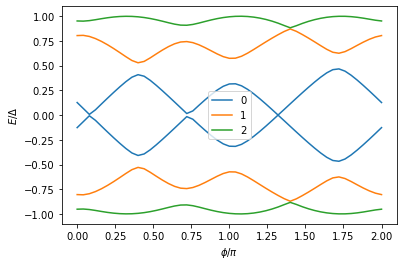

In [21]:
mu = 0.01
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
phases = np.linspace(0,2,51)
plot_ABS_spectrum(systf1, params_TI, phases)

#### Multi-channel with calibrated phase shift

<ipython-input-15-659a66df2e0c>:106: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.linalg.eigvalsh(operator[2]))


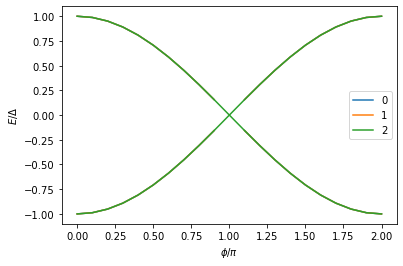

Time elapsed :  251.86134934425354 Time remaining :  5037.226986885071 Percentage :  4.761904761904762


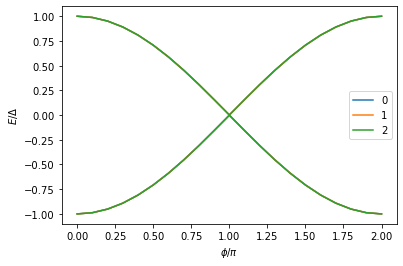

Time elapsed :  483.0706431865692 Time remaining :  4589.1711102724075 Percentage :  9.523809523809524


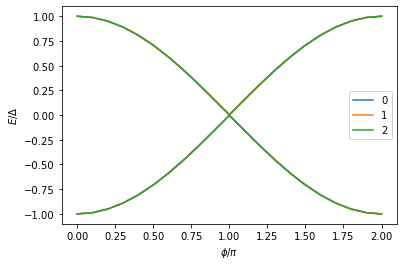

Time elapsed :  602.648344039917 Time remaining :  3615.890064239502 Percentage :  14.285714285714285


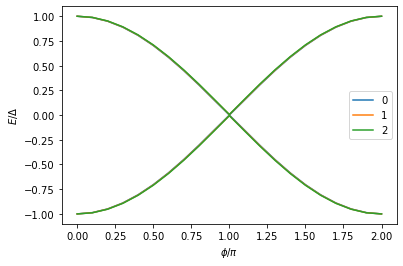

Time elapsed :  721.6200706958771 Time remaining :  3066.8853004574776 Percentage :  19.047619047619047


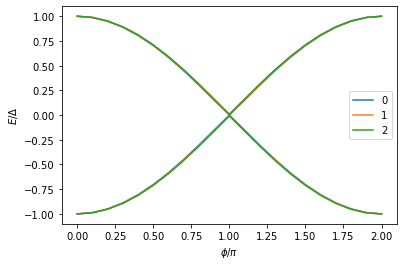

Time elapsed :  840.6589789390564 Time remaining :  2690.1087326049806 Percentage :  23.809523809523807


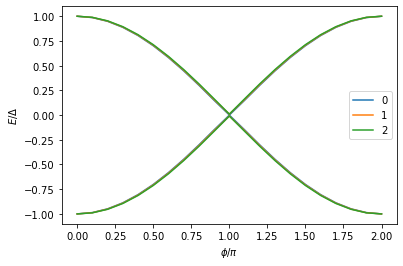

Time elapsed :  960.0341534614563 Time remaining :  2400.0853836536407 Percentage :  28.57142857142857


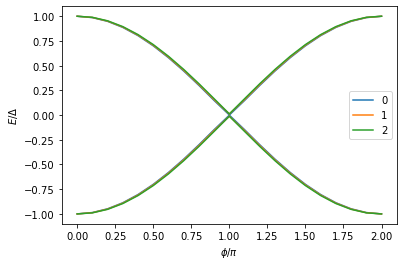

Time elapsed :  1079.0257890224457 Time remaining :  2158.0515780448914 Percentage :  33.33333333333333


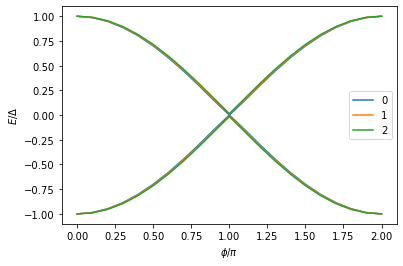

Time elapsed :  1197.8903954029083 Time remaining :  1946.571892529726 Percentage :  38.095238095238095


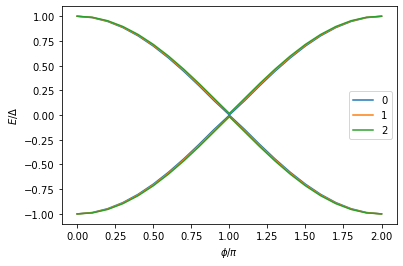

Time elapsed :  1316.7830185890198 Time remaining :  1755.7106914520264 Percentage :  42.857142857142854


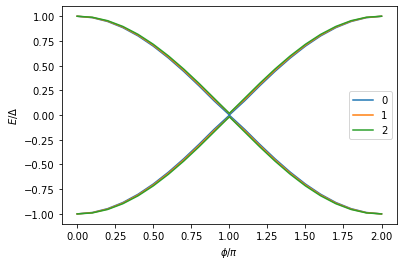

Time elapsed :  1435.5095102787018 Time remaining :  1579.060461306572 Percentage :  47.61904761904761


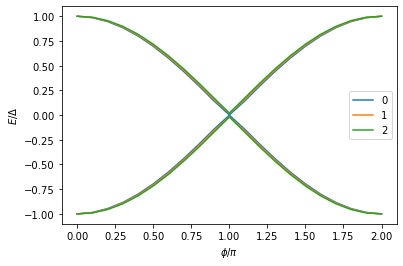

Time elapsed :  1554.9261305332184 Time remaining :  1413.569209575653 Percentage :  52.38095238095239


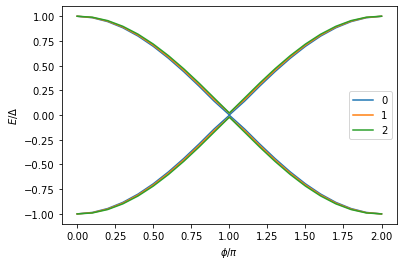

Time elapsed :  1674.4637823104858 Time remaining :  1255.8478367328644 Percentage :  57.14285714285714


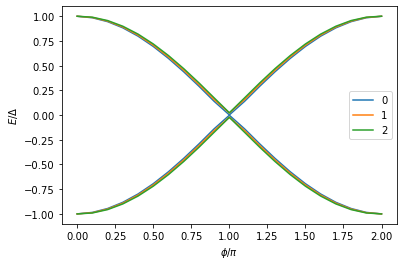

Time elapsed :  1794.1991229057312 Time remaining :  1104.1225371727573 Percentage :  61.904761904761905


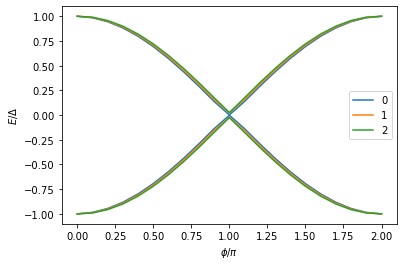

Time elapsed :  1914.9085400104523 Time remaining :  957.4542700052261 Percentage :  66.66666666666666


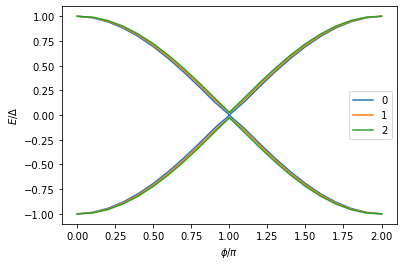

Time elapsed :  2034.4523012638092 Time remaining :  813.7809205055237 Percentage :  71.42857142857143


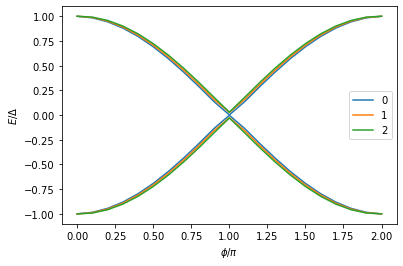

Time elapsed :  2153.8718235492706 Time remaining :  673.0849448591471 Percentage :  76.19047619047619


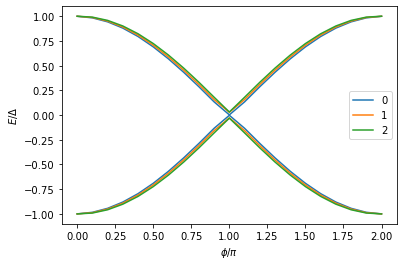

Time elapsed :  2273.0360383987427 Time remaining :  534.8320090349985 Percentage :  80.95238095238095


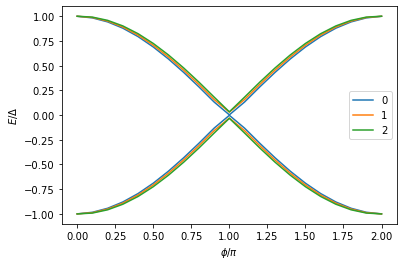

Time elapsed :  2393.4277188777924 Time remaining :  398.9046198129654 Percentage :  85.71428571428571


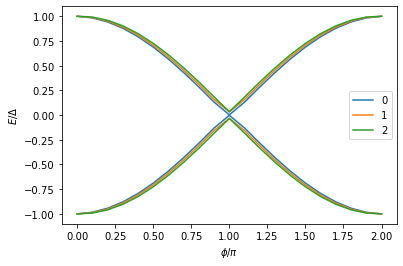

Time elapsed :  2513.190036058426 Time remaining :  264.54631958509754 Percentage :  90.47619047619048


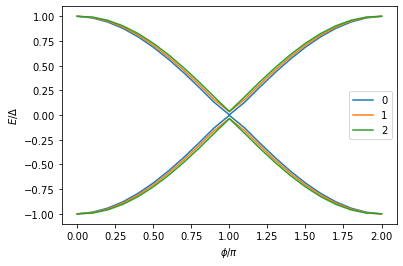

Time elapsed :  2632.83518743515 Time remaining :  131.64175937175787 Percentage :  95.23809523809523


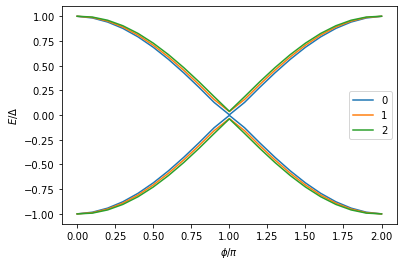

Time elapsed :  2752.4315795898438 Time remaining :  0.0 Percentage :  100.0


In [19]:
import time

mu = 0.05   # get rid of the potential mismatch and add in disorder. for same potential all ABS become MBS
params_TI['mu_bulk'] = mu   ### cor disorder produces values with function, uncor disorder tot random
params_TI['mu_lead1'] = mu           # diff in potential creates backscattering, which affects transmission
params_TI['mu_lead2'] = mu
params_TI["S_imp"] = get_S_imp_3D()

s_mag = np.linspace(0,0.01,21)
phases = np.linspace(0,2,21)

time_start = time.time()

for i in range(len(s_mag)):
    params_TI["S_mag"] = s_mag[i]
    results = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)
    plt.savefig(fname = f".\\Images\\multi_channel_0.5_{s_mag[i]}.pdf")
    plt.show()
    
    time_current = time.time()
    percentage = (i + 1)/len(s_mag)
    time_left = (time_current - time_start)/percentage - (time_current - time_start) 

    print("Time elapsed : ", time_current - time_start, "Time remaining : ", time_left, "Percentage : ", percentage*100)



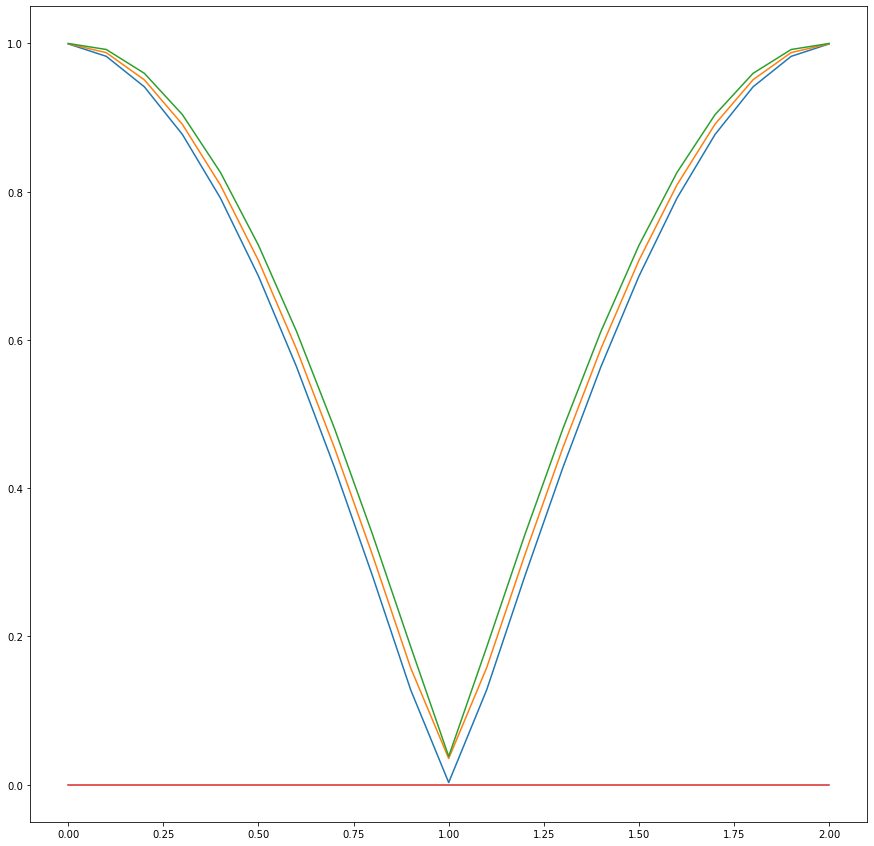

In [25]:
plt.figure(figsize=(15,15))
plt.plot(phases, results[0])
plt.plot(phases, results[1])
plt.plot(phases, results[2])
a = np.zeros(phases.size)
plt.plot(phases, a)
plt.show()


<ipython-input-11-bfbfba58b8dd>:25: RuntimeWarning: invalid value encountered in true_divide
  ind_x = int(site.pos[0]/a)


UserCodeError: Error occurred in user-supplied value function "onsite".
See the upper part of the above backtrace for more information.

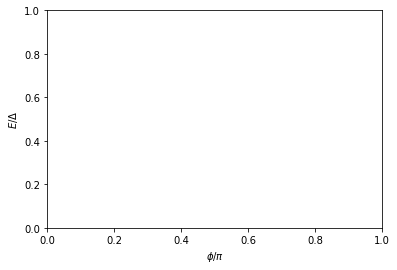

In [26]:

mu = 0.05   # get rid of the potential mismatch and add in disorder. for same potential all ABS become MBS
params_TI['mu_bulk'] = mu   ### cor disorder produces values with function, uncor disorder tot random
params_TI['mu_lead1'] = mu           # diff in potential creates backscattering, which affects transmission
params_TI['mu_lead2'] = mu
params_TI["S_imp"] = get_S_imp_3D()

s_mag_s = 0.02
phases = np.linspace(0,2,21)


params_TI["S_mag"] = s_mag
resultssss = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, r=True)
plt.savefig(fname = f".\\Images\\multi_channel_0.5_{s_mag[i]}.png")
plt.show()


plt.figure(figsize=(15,15))
plt.plot(phases, results[0])
plt.plot(phases, results[1])
plt.plot(phases, results[2])
a = np.zeros(phases.size)
plt.plot(phases, a)
plt.show()

## Tasks

### Varying bulk chemical potentials (single channel)

In [ ]:
np.linspace(-0.032, 0.2, 9)

mus = np.linspace(-0.05, 0.2, 51)
Smags = np.linspace(0, 0.05, 51)
gaps = []
params_TI['mu_lead1'] = 0.05
params_TI['mu_lead2'] = 0.05

for mu in mus:
    gap_mu = []
    params_TI['mu_bulk'] = 0.042+mu
    for s in Smags:
        params_TI['S_mag'] = s
        gap = find_gap(systf1, params_TI)
        #print(gap)
        gap_mu.append(gap)
    gaps.append(gap_mu)
    
switches = [0.004, 0.042, 0.08, 0.12, 0.158, 0.196]

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

mus = np.linspace(0.01, 0.05, 5)

i = 0
for mu in mus:
    params_TI['mu_bulk'] = mu

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, ph_sym=False, phases=phase, method='mask'))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=r'$\mu_bulk$={0:.2f}'.format(mu))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying uncorrelated disorder strength (single channel)

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_3D()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, ph_sym=False, phases=phase, method='mask'))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label="S_mag={0:.2f}".format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying correlated disorder strength (single channel)

In [ ]:
print('Correlation length is {}'.format(correlation_length))
print('Lattice size is {}'.format(a))

params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_correlated()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, ph_sym=False, phases=phase, method='mask'))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label='S_mag={0:.2f}'.format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

# Appendix

## Band Structure

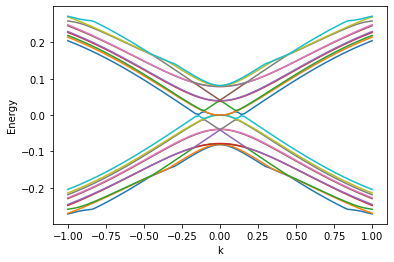

[[-0.27143675 -0.26965286 -0.25857722 ...  0.25857722  0.26965286
   0.27143675]
 [-0.26970779 -0.2666643  -0.25735122 ...  0.25735122  0.2666643
   0.26970779]
 [-0.26741203 -0.26353445 -0.2558935  ...  0.2558935   0.26353445
   0.26741203]
 ...
 [-0.26741203 -0.26353445 -0.2558935  ...  0.2558935   0.26353445
   0.26741203]
 [-0.26970779 -0.2666643  -0.25735122 ...  0.25735122  0.2666643
   0.26970779]
 [-0.27143675 -0.26965286 -0.25857722 ...  0.25857722  0.26965286
   0.27143675]]


In [21]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        plt.show()
    if return_bands:
        return energies
    

params_TI['mu_bulk'] = 0
params_TI['mu_lead1'] = 0
params_TI['mu_lead2'] = 0    
momenta = np.linspace(-1, 1, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=10, params=params_TI)

print(r1)

## Visualise the disorder profile

In [ ]:
from matplotlib import cm

S_mag = 0.01

z=S_mag * disorder_fil.mean(axis =(2))*1000

x=np.linspace(0,L_x//a,L_x//a+1)
y=np.linspace(0,10,11) # Why is it ten?
X, Y = np.meshgrid(x, y)

fig, axs=plt.subplots(figsize=(10,5))

cs=axs.contourf(X,Y,z,cmap=cm.PuBu_r)
# plot = plt.contourf(X,Y,filter_kernel)
# plt.axis('scaled')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')


axs.set_aspect(10)

cbar=fig.colorbar(cs, orientation='horizontal', label='Chemical Potential Disorder (meV)')
plt.show()

In [ ]:
xval=np.linspace(0,L_x//a,L_x//a+1)
xvals=xval.astype(int)
dis=[]
dis2=[]
S_mag = 0.02
for x in xvals:
      dis.append(S_mag*disorder[0,x,0])

for x in xvals:
      dis2.append(S_mag*disorder_fil[0,x,0])
        
plt.plot(xvals,dis,label='Unfiltered')
plt.plot(xvals,dis2,linewidth=7,label='filtered')
plt.xlabel('x-coordinate (nm)')
plt.ylabel('Disorder (meV)')
plt.legend()
plt.show()

In [ ]:
disorder[0,1,0]